# DCT example visualization for a single image

The best parameters found (with the dataset without noise) are used to visualize what happens to a single image going through all the processing involved in the DCT.

### Imports

In [83]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

### Constants

In [84]:
query_folder = "./data/qsd1_w3/non_augmented/"
bbdd_folder = "./data/BBDD"

### Helper functions

In [143]:
def plot_image(image):
    """
    Displays an image using OpenCV and Matplotlib.
    
    Parameters:
        image (str): the loaded image.
    """
    # 1D color channelimage
    if len(image.shape)==2:
        plt.imshow(image, cmap="gray")
    # 3D color channel image
    else:
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(image_rgb)
    plt.axis('off')
    plt.show()
    
def split_image_into_quadrants(image, level):
    if level == 0:
        return [image]
    height, width, _ = image.shape
    center_x, center_y = width // 2, height // 2

    # Split image into quadrants
    top_left = image[0:center_y, 0:center_x]
    top_right = image[0:center_y, center_x:width]
    bottom_left = image[center_y:height, 0:center_x]
    bottom_right = image[center_y:height, center_x:width]

    # Recursively split each quadrant
    top_left_quadrants = split_image_into_quadrants(top_left, level - 1)
    top_right_quadrants = split_image_into_quadrants(top_right, level - 1)
    bottom_left_quadrants = split_image_into_quadrants(bottom_left, level - 1)
    bottom_right_quadrants = split_image_into_quadrants(bottom_right, level - 1)

    # Calculate the number of tiles per row at this level
    tiles_per_row = 2 ** (level - 1)

    # Combine quadrants in row-major order so they can be plotted correctly
    top_row = []
    bottom_row = []
    for i in range(0, len(top_left_quadrants), tiles_per_row):
        top_row.extend(top_left_quadrants[i:i+tiles_per_row] + top_right_quadrants[i:i+tiles_per_row])
    for i in range(0, len(bottom_left_quadrants), tiles_per_row):
        bottom_row.extend(bottom_left_quadrants[i:i+tiles_per_row] + bottom_right_quadrants[i:i+tiles_per_row])

    return top_row + bottom_row

def plot_quadrants(quadrants, save=False):
    # Calculate the grid size
    num_quadrants = len(quadrants)
    grid_size = int(num_quadrants ** 0.5)
    
    # Create the plot
    fig, axs = plt.subplots(grid_size, grid_size, figsize=(5, 5))
    
    # Plot each quadrant
    for i, quadrant in enumerate(quadrants):
        ax = axs[i // grid_size, i % grid_size]
        ax.imshow(cv2.cvtColor(quadrant, cv2.COLOR_BGR2RGB))
        ax.axis('off')
    
    if save:
        plt.savefig("quadrants.jpg")
    plt.tight_layout()
    plt.show()

def compute_images_block_dct(images, block_size=8):
    """
    Given a list of images, computes the Discrete Cosine Transform (DCT) for each image by blocks.

    Args:
    - images (list): List of images.
    - block_size (int): The size of the blocks for which the DCT will be computed.

    Returns:
    - block_dct_images (list): A list of lists of DCTs for each image, where each image's DCT is divided into blocks.
    """

    block_dct_images = []

    for img in images:
        img_float32 = np.float32(img)  # Convert image to float32 for DCT calculation
        height, width = img.shape
        dct_blocks = []

        # Iterate over the image in block-sized steps
        for i in range(0, height, block_size):
            for j in range(0, width, block_size):
                # Extract the block
                block = img_float32[i:i + block_size, j:j + block_size]

                # Compute the DCT for the block
                dct_block = cv2.dct(block)

                # Append the DCT of the block to the list for this image
                dct_blocks.append(dct_block)

        # Append the list of DCT blocks for this image to the final result
        block_dct_images.append(dct_blocks)

    return block_dct_images

def plot_dct_blocks(quadrants, save=False):
    # Calculate the grid size
    num_quadrants = len(quadrants)
    grid_size = int(num_quadrants ** 0.5)
    
    # Create the plot
    fig, axs = plt.subplots(grid_size, grid_size, figsize=(5, 5))
    
    # Plot each quadrant
    for i, quadrant in enumerate(quadrants):
        ax = axs[i // grid_size, i % grid_size]
        ax.imshow(quadrant)
        ax.axis('off')
    
    if save:
        plt.savefig("quadrants.jpg")
    plt.tight_layout()
    plt.show()

def zigzag_indices(N):
    """
    Generates the zigzag order indices for an NxN block.
    
    Args:
    - block_size (int): The size of the DCT block (e.g., 8 for an 8x8 block).
    
    Returns:
    - zigzag (list): Indices indicating the zigzag order of the block.
    """
    indices = []
    for k in range(2 * N - 1):
        if k % 2 == 0:
            i_start = min(k, N - 1)
            i_end = max(0, k - N + 1)
            for i in range(i_start, i_end - 1, -1):
                j = k - i
                indices.append(i * N + j)
        else:
            i_start = max(0, k - N + 1)
            i_end = min(k, N - 1)
            for i in range(i_start, i_end + 1):
                j = k - i
                indices.append(i * N + j)
    return indices

def extract_dct_coefficients_zigzag(block_dct_images, num_coefs, block_size=8):
    """
    Extracts the first num_coefs coefficients in zigzag order from each block DCT for each image, and concatenates 
    these coefficients into a single vector per image.

    Args:
    - block_dct_images (list of lists): List of images, where each 
                                        image is a list of DCT blocks.
    - num_coefs (int): The number of DCT coefficients to extract from each block in zigzag order.
    - block_size (int): The size of the blocks used in DCT.

    Returns:
    - dct_vectors (list of lists): A list of vectors, each representing the concatenation 
                                   of the first K coefficients from each DCT block for each image.
    """

    # Get the zigzag indices for an 8x8 block
    zigzag = zigzag_indices(block_size)
    
    dct_vectors = []

    for blocks in block_dct_images:
        image_vector = []

        for block_dct in blocks:
            # Extract the coefficients in zigzag order
            zigzag_coeffs = zigzag_indices(block_size)
            flattened_block = block_dct.flatten()
            reordered_block_dct = flattened_block[zigzag_coeffs]
            first_coefs = reordered_block_dct[:num_coefs]

            # Append the num_coefs zigzag coefficients to the image vector
            image_vector.extend(first_coefs)

        # Append the concatenated vector for this image to the final list
        dct_vectors.append(image_vector)

    return dct_vectors

def plot_8x8_grid(data):
    if len(data) != 1024:
        raise ValueError("Input data must contain exactly 1024 elements.")
    
    reshaped_data = np.array(data).reshape(64, 4, 4)
    
    fig, axes = plt.subplots(8, 8, figsize=(6, 6))

    for i in range(8):
        for j in range(8):
            block = reshaped_data[i * 8 + j]
            ax = axes[i, j]
            ax.imshow(block, cmap='viridis', vmin=np.min(data), vmax=np.max(data))
            ax.axis('off')
            
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

def plot_1x1024_vector(data):
    if len(data) != 1024:
        raise ValueError("Input data must contain exactly 1024 elements.")
    
    data_array = np.array(data).reshape(1, 1024)

    fig, ax = plt.subplots(figsize=(15, 2))

    ax.imshow(data_array, aspect='auto', cmap='viridis', extent=[0, 1024, 0, 1])

    ax.set_yticks([])
    ax.set_xticks([])
    
    ax.set_xlim([0, 1024])

    plt.show()

### 1. The image is loaded

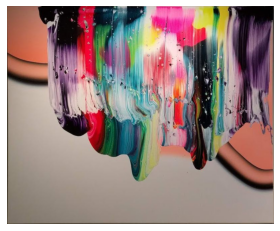

Shape: (652, 799, 3)


In [113]:
# Path to example image of choice
image_path = os.path.join(query_folder, "00000.jpg")
image = cv2.imread(image_path)

plot_image(image)
print("Shape:", image.shape)

### 2. The image is resized to 256x256 pixels

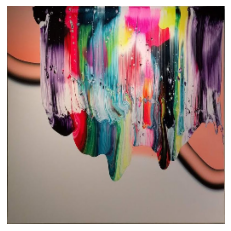

Shape: (256, 256, 3)


In [114]:
image = cv2.resize(image, (256, 256))

plot_image(image)
print("Shape:", image.shape)

### 3. The image is transformed to a one dimensional color space (V from HSV in this case)

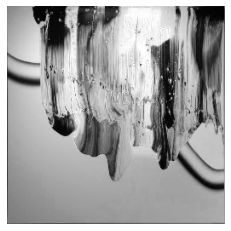

Shape: (256, 256)


In [115]:
hsv_img = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
V_channel = hsv_img[:, :, 2]

plot_image(V_channel)
print("Shape:", V_channel.shape)

### 4. The image is split into blocks (size 32x32 pixels in this case)

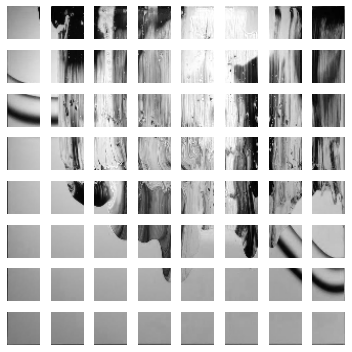

In [116]:
quadrants = split_image_into_quadrants(np.expand_dims(V_channel, axis=-1), 3)
plot_quadrants(quadrants)

### 5. The DCT is calculated for each block

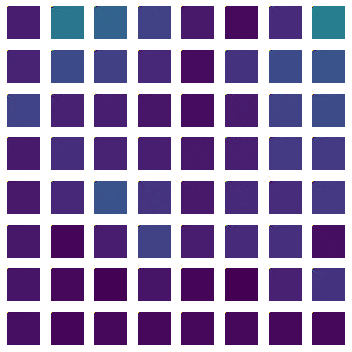

In [117]:
dct_blocks = compute_images_block_dct([V_channel], block_size=32)

plot_dct_blocks(dct_blocks[0])

#### Closer inspection a DCT block (out of the 64 generated)

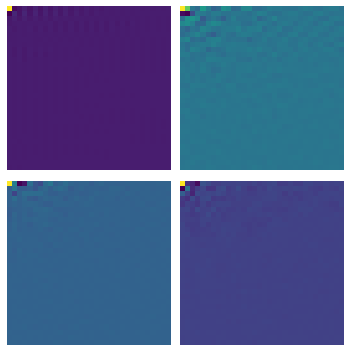

In [118]:
plot_dct_blocks(dct_blocks[0][0:4])

### 6. For each DCT block, the first K coefficients are extracted (16 in this case)

In [119]:
dct_coeffs = extract_dct_coefficients_zigzag(dct_blocks, 16, 32)

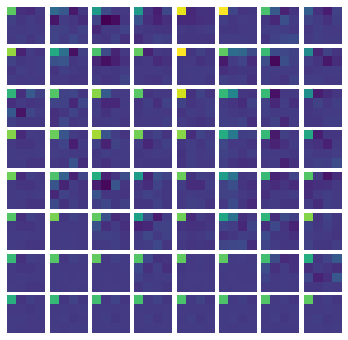

In [128]:
plot_8x8_grid(dct_coeffs[0])

### 7. All the coefficients are concatenated into a single feature vector (64\*16=1024 dimensions in this case)

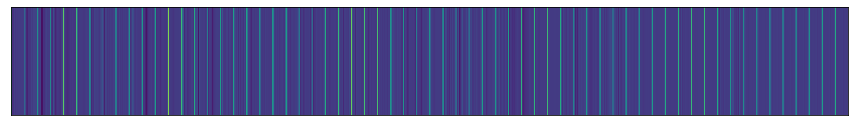

In [144]:
plot_1x1024_vector(dct_coeffs[0])

These feature vectors are then compared to perform the image retrieval.